In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/image-colorization/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/image-colorization/ab/ab/ab3.npy
/kaggle/input/image-colorization/ab/ab/ab1.npy
/kaggle/input/image-colorization/ab/ab/ab2.npy
/kaggle/input/image-colorization/l/gray_scale.npy


In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,InputLayer, Conv2DTranspose, Dropout, BatchNormalization, Input, Concatenate, Activation, concatenate ,RepeatVector ,Reshape ,UpSampling2D
from keras.initializers import RandomNormal
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import cv2
import PIL
from skimage import transform
from PIL import Image
import random
import h5py
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt


# **> Loading the Data......**

In [29]:
images_gray = np.load("../input/image-colorization/l/gray_scale.npy")
images_ab1 = np.load("../input/image-colorization/ab/ab/ab1.npy")
images_ab2 = np.load("../input/image-colorization/ab/ab/ab2.npy")
images_ab3 = np.load("../input/image-colorization/ab/ab/ab3.npy")



# Creating samples for Training 

In [30]:
#taking training data of 100
X_train = (images_gray[:100,:,:].astype('float')).reshape(100,224,224,1) #reshaping the input gray images
Y = (images_ab1[:100,:,:].astype('float'))


# Loading pretrained Model ..... Inception-ResNet-v2

In [31]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('../input/image-colorization/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

In [32]:
#To generate embeddings of 1000*1 by passing input images through InceptionResNetV2
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed
import tensorflow as tf

In [33]:
incept_em = create_inception_embedding(X_train)
embeddings = RepeatVector(28 * 28)(incept_em)
layer_embeddings = Reshape(([28, 28, 1000]))(embeddings)

# THE MODEL

In [34]:
model_path = "./color_model.h5"
checkpoint = ModelCheckpoint(model_path,
                            monitor = "val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose = 1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [35]:
#Encoder
embed_input = Input(shape=(28, 28, 1000))
encoder_input = Input(shape=(224, 224, 1,))
encoder_1 = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_2 = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_1)
encoder_3 = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_2)
encoder_4 = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_3)
encoder_5 = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_4)
encoder_6 = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_5)
encoder_7 = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_6)
encoder_output= Conv2D(256, (3,3), activation='relu', padding='same')(encoder_7)
#Fusion layer
fusion_output = concatenate([encoder_output, layer_embeddings], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
#Decoder layer
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=[encoder_input,embed_input], outputs=decoder_output)
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_669 (Conv2D)             (None, 112, 112, 64) 640         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_670 (Conv2D)             (None, 112, 112, 128 73856       conv2d_669[0][0]                 
__________________________________________________________________________________________________
conv2d_671 (Conv2D)             (None, 56, 56, 128)  147584      conv2d_670[0][0]                 
_______________________________________________________________________________________

# Training.....

In [36]:
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
history = model.fit(x=[X_train,layer_embeddings] ,y=Y,callbacks = [checkpoint,es], batch_size=5, epochs=1000,steps_per_epoch=1)

Train on 1 samples
Epoch 1/1000
1/1 [==============================] - 0s 3ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 18084.6621 - acc: 0.5534
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 12665.2324 - acc: 0.5517
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 17966.9004 - acc: 0.5562
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 18013.6562 - acc: 0.4471
Epoch 5/1000
1/1 [==============================] - 0s 3ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 17708.6230 - acc: 0.4478
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 13297.4316 - acc: 0.4486
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 37708.6055 - acc: 0.4473
Epoch 8/1000
1/1 [==============================] - 0s 4m

1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 3769.5029 - acc: 0.5426
Epoch 63/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 4352.8560 - acc: 0.5464
Epoch 64/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 3983.9446 - acc: 0.5468
Epoch 65/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 4269.6440 - acc: 0.5483
Epoch 66/1000
1/1 [==============================] - 0s 9ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 3794.1997 - acc: 0.5494
Epoch 67/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 4141.1958 - acc: 0.5497
Epoch 68/1000
1/1 [==============================] - 0s 3ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 3737.3723 - acc: 0.5498
Epoch 69/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - siz

Epoch 124/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 2186.2651 - acc: 0.5493
Epoch 125/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 3047.5813 - acc: 0.5334
Epoch 126/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 3345.9302 - acc: 0.5521
Epoch 127/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 3596.4448 - acc: 0.5527
Epoch 128/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 2138.1077 - acc: 0.5519
Epoch 129/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 4229.0552 - acc: 0.5426
Epoch 130/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 2262.4016 - acc: 0.5527
Epoch 131/1000
1/1 [==============================] - 0s 4ms/step - b

1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 1771.3937 - acc: 0.5501
Epoch 186/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 1771.2740 - acc: 0.5511
Epoch 187/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 678.7461 - acc: 0.5512
Epoch 188/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 2159.8660 - acc: 0.5508
Epoch 189/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 788.1877 - acc: 0.5512
Epoch 190/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 1663.6012 - acc: 0.5517
Epoch 191/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 1231.2654 - acc: 0.5518
Epoch 192/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 

1/1 [==============================] - 0s 5ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 357.3969 - acc: 0.5472
Epoch 248/1000
1/1 [==============================] - 0s 3ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 357.3510 - acc: 0.5473
Epoch 249/1000
1/1 [==============================] - 0s 6ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 355.1679 - acc: 0.5477
Epoch 250/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 355.1831 - acc: 0.5480
Epoch 251/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 352.9060 - acc: 0.5481
Epoch 252/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 352.8781 - acc: 0.5482
Epoch 253/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 351.1978 - acc: 0.5484
Epoch 254/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - siz

1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 328.9651 - acc: 0.5505
Epoch 310/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 328.4251 - acc: 0.5507
Epoch 311/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 328.1730 - acc: 0.5507
Epoch 312/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 327.7410 - acc: 0.5508
Epoch 313/1000
1/1 [==============================] - 0s 5ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 327.2054 - acc: 0.5508
Epoch 314/1000
1/1 [==============================] - 0s 5ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 326.8361 - acc: 0.5509
Epoch 315/1000
1/1 [==============================] - 0s 10ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 326.5256 - acc: 0.5508
Epoch 316/1000
1/1 [==============================] - 0s 3ms/step - batch: 0.0000e+00 - si

1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 325.7520 - acc: 0.5521
Epoch 372/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 312.4657 - acc: 0.5520
Epoch 373/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 319.9550 - acc: 0.5520
Epoch 374/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 315.4501 - acc: 0.5520
Epoch 375/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 315.0535 - acc: 0.5520
Epoch 376/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 317.1013 - acc: 0.5520
Epoch 377/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 311.7201 - acc: 0.5519
Epoch 378/1000
1/1 [==============================] - 0s 3ms/step - batch: 0.0000e+00 - siz

1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 307.1621 - acc: 0.5519
Epoch 434/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 311.1508 - acc: 0.5519
Epoch 435/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 296.9945 - acc: 0.5519
Epoch 436/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 306.9211 - acc: 0.5519
Epoch 437/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 307.5349 - acc: 0.5519
Epoch 438/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 296.7492 - acc: 0.5519
Epoch 439/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 308.1782 - acc: 0.5519
Epoch 440/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - siz

1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 338.3858 - acc: 0.5518
Epoch 496/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 340.3284 - acc: 0.5518
Epoch 497/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 341.3562 - acc: 0.5519
Epoch 498/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 333.8471 - acc: 0.5518
Epoch 499/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 327.6105 - acc: 0.5519
Epoch 500/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 322.6749 - acc: 0.5519
Epoch 501/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 320.6532 - acc: 0.5519
Epoch 502/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - siz

1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 284.2419 - acc: 0.5518
Epoch 558/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 283.1111 - acc: 0.5518
Epoch 559/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 281.8596 - acc: 0.5518
Epoch 560/1000
1/1 [==============================] - 0s 5ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 278.4654 - acc: 0.5518
Epoch 561/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 276.9689 - acc: 0.5518
Epoch 562/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 278.1370 - acc: 0.5518
Epoch 563/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 279.5801 - acc: 0.5518
Epoch 564/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - siz

1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 269.9193 - acc: 0.5518
Epoch 620/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 268.4171 - acc: 0.5518
Epoch 621/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 267.8197 - acc: 0.5518
Epoch 622/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 267.9988 - acc: 0.5518
Epoch 623/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 268.7628 - acc: 0.5518
Epoch 624/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 270.4268 - acc: 0.5518
Epoch 625/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 272.9823 - acc: 0.5518
Epoch 626/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - siz

1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 264.7242 - acc: 0.5519
Epoch 682/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 270.0511 - acc: 0.5519
Epoch 683/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 269.8367 - acc: 0.5519
Epoch 684/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 267.4171 - acc: 0.5519
Epoch 685/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 262.6703 - acc: 0.5519
Epoch 686/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 260.7546 - acc: 0.5519
Epoch 687/1000
1/1 [==============================] - 0s 3ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 261.6101 - acc: 0.5519
Epoch 688/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - siz

1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 258.4429 - acc: 0.5519
Epoch 744/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 262.5553 - acc: 0.5519
Epoch 745/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 269.3139 - acc: 0.5519
Epoch 746/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 272.6006 - acc: 0.5519
Epoch 747/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 283.1363 - acc: 0.5519
Epoch 748/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 281.7140 - acc: 0.5519
Epoch 749/1000
1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 286.4204 - acc: 0.5519
Epoch 750/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - siz

1/1 [==============================] - 0s 5ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 258.2238 - acc: 0.5519
Epoch 806/1000
1/1 [==============================] - 0s 3ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 255.4801 - acc: 0.5519
Epoch 807/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 252.4954 - acc: 0.5519
Epoch 808/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 251.9013 - acc: 0.5519
Epoch 809/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 253.5563 - acc: 0.5519
Epoch 810/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 256.4037 - acc: 0.5519
Epoch 811/1000
1/1 [==============================] - 0s 3ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 257.2291 - acc: 0.5518
Epoch 812/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - siz

1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 247.2139 - acc: 0.5518
Epoch 868/1000
1/1 [==============================] - 0s 3ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 247.0088 - acc: 0.5518
Epoch 869/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 246.9802 - acc: 0.5518
Epoch 870/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 247.0945 - acc: 0.5518
Epoch 871/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 247.5407 - acc: 0.5518
Epoch 872/1000
1/1 [==============================] - 0s 6ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 248.9901 - acc: 0.5518
Epoch 873/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 254.0826 - acc: 0.5518
Epoch 874/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - siz

1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 248.8010 - acc: 0.5518
Epoch 930/1000
1/1 [==============================] - 0s 3ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 248.6528 - acc: 0.5518
Epoch 931/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 247.4360 - acc: 0.5518
Epoch 932/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 247.6899 - acc: 0.5518
Epoch 933/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 248.0114 - acc: 0.5519
Epoch 934/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 247.2017 - acc: 0.5519
Epoch 935/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 246.8143 - acc: 0.5519
Epoch 936/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - siz

1/1 [==============================] - 0s 4ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 244.6396 - acc: 0.5520
Epoch 992/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 246.8049 - acc: 0.5520
Epoch 993/1000
1/1 [==============================] - 0s 3ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 249.6628 - acc: 0.5520
Epoch 994/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 248.9451 - acc: 0.5520
Epoch 995/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 248.5076 - acc: 0.5520
Epoch 996/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 245.0628 - acc: 0.5520
Epoch 997/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 242.5011 - acc: 0.5520
Epoch 998/1000
1/1 [==============================] - 0s 2ms/step - batch: 0.0000e+00 - siz

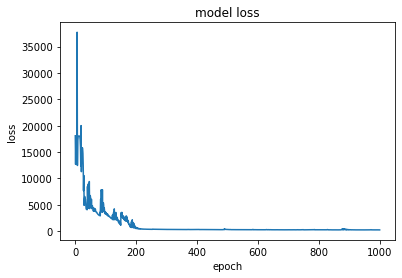

In [43]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [44]:
output = model.predict([X_train,layer_embeddings],steps=3)


In [71]:
def get_LAB(image_l, image_ab  ):
       
    image_l = image_l.reshape((224, 224, 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    image_lab = image_lab.astype("uint8")
 
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb
def get_LAB1(image_l  ):
    image_ab =  np.ones((224,224,2))*128
    image_l = image_l.reshape((224, 224, 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    image_lab = image_lab.astype("uint8")
 
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb

NameError: name 'ax' is not defined

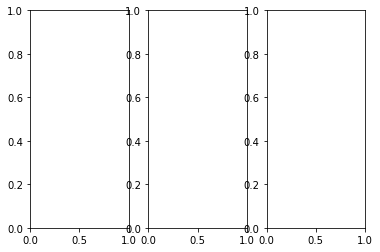

In [85]:
for i in range(50):
    pred = get_LAB(X_train[i],output[i])
    real = get_LAB(X_train[i],Y[i])
    original = get_LAB1(X_train[i])
    f, axarr = plt.subplots(1,3)
    axarr[0].title.set_text('Black and white')  
    axarr[1].title.set_text('Prediction')  
    axarr[2].title.set_text('original')  
    axarr[0].imshow(original)
    axarr[1].imshow(pred)
    axarr[2].imshow(real)
    
    
    